# Industry Accelerators - Utilities Customer Attrition Prediction Model

## Introduction

In this notebook we will go through the end-to-end process of importing raw data, preparing the data, testing machine learning models, selecting the best performing model and deploying a pipeline. The model predicts how likely a customer is to attrit based on customer demographic and Utilities retail details, as well as their historical energy usage. We will use sklearn transformers and a pipeline to complete the steps of transforming the raw data and building a machine learning model, before deploying the pipeline using Watson Machine Learning.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In the cell below we import the python libraries that we will use throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

## Functions

The following cell contains a function which generates a number of plots which are used for some preliminary analysis. The first chart shows the distribution of the variable passed to the function. If the variable is numerical, a second plot is generated which shows the variable bucketed up. The last plot shows the percentage of attited cases within each bucket for numerical variables or within each category for categorical variables. This gives the data scientist an idea of what single variables can influence attrition.  

In [2]:
def plot_distribution_and_target_density(df, col_name, chart_type, target_col):
    if chart_type == 'numerical':
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 14))
        plt.subplots_adjust(hspace = 0.4)
        ax1.set_title('Variable Distribution - ' + col_name)
        dist_plt = sns.distplot(df[col_name], kde=False, ax=ax1)   
        # bin the numerical data
        # if there are less than 10 unique numbers, just split into the number of unique numbers
        if len(df[col_name].unique()) < 10:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], len(df[col_name].unique())-1)
        else:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], 10)
        col_name = col_name + '_BINNED'
        

    elif chart_type == 'categorical':
        fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(14, 10))
        plt.subplots_adjust(hspace = 0.4)

    df_var_summary = df.groupby(col_name)[target_col].agg(['count', 'mean']).reset_index()
    df_var_summary.rename(columns={'count':'Number of Records', 'mean':'Target Density'}, inplace=True)
    
    # if we are using a binned variable sort binning lowest to highest
    # we can also drop it from the raw data now
    # if categorical, sort by the number of records
    if chart_type == 'numerical': 
        df_var_summary.sort_values(col_name, inplace=True)
        df.drop(col_name, axis=1, inplace=True)
    elif chart_type == 'categorical':
        df_var_summary.sort_values('Number of Records', inplace=True, ascending=False)

    ax2.set_title('Number of Records per Category - ' + col_name)

    category_plt = sns.barplot(x=col_name,y='Number of Records',data=df_var_summary, color="skyblue", ax=ax2)
    category_plt = category_plt.set_xticklabels(category_plt.get_xticklabels(), rotation=30, horizontalalignment='right')
    category_plt = ax2.set_xlabel('')

    target_density_plot = sns.barplot(x=col_name, y='Target Density', data=df_var_summary, color="skyblue", ax=ax3)

    ax3.set_title('Target Density per Category - ' + col_name)

    for patch in ax3.patches:
        bar_height = patch.get_height()
        ax3.text(patch.get_x()+patch.get_width()/2.,
                bar_height/2,
                np.round(bar_height, 2),
                ha='center', color='white', weight='bold', fontsize=10) 

    target_density_plot.axhline(y=df[target_col].mean(), ls='--')
    target_density_plot.text(1, df[target_col].mean() + 0.01, 'Average Target Density :' + str(np.round(df[target_col].mean(), 2)), fontsize=10, va='center', ha='center')
    target_density_plot = target_density_plot.set_xticklabels(target_density_plot.get_xticklabels(), rotation=30, horizontalalignment='right')
    target_density_plot = ax3.set_xlabel('')
    
    return

## Load Customer Attrition Data

We provide a dataset with demographical and behavioural attributes for our customers. Each customer has one record in the dataset and is stamped with whether the customer attrited or not. The SQL query to create the dataset is included in the project. The cells below import the data and display a sample of the raw data.

In [3]:
df_prep = pd.read_csv('/project_data/data_asset/Attrition View.csv')

In [4]:
df_prep.head()

,CUSTOMER_ID,GENDER_ID,FIRST_NAME,LAST_NAME,PHONE_1,EMAIL,AGE,ENERGY_USAGE_PER_MONTH,ENERGY_EFFICIENCY,IS_REGISTERED_FOR_ALERTS,...,SEGMENT,EMPLOYMENT,STD_YRLY_USAGE_CUR_YEAR_MINUS_1,STD_YRLY_USAGE_CUR_YEAR_MINUS_2,STD_YRLY_USAGE_CUR_YEAR_MINUS_3,STD_YRLY_USAGE_CUR_YEAR_MINUS_4,STD_YRLY_USAGE_CUR_YEAR_MINUS_5,STD_YRLY_USAGE_CUR_YEAR_MINUS_6,STD_YRLY_USAGE_CUR_YEAR_MINUS_7,MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1
0,1,2,Leonor,Cummerata,781-757-3537,Leonor.Cummerata@nola.biz,44,5080,0.390,1,...,PLATINUM,Employed full-time,56049,43703,26666,26666,28642,26666,22963,20500
1,2,1,Ima,Labadie,505-339-5197,Ima.Labadie@allie.tv,34,4970,0.356,0,...,GOLD,Employed full-time,52098,40740,26666,26666,26666,26666,21481,20500
2,3,1,Brycen,Hermiston,309-713-5431,Brycen.Hermiston@kristina.biz,39,9250,0.628,1,...,GOLD,Employed full-time,52098,40740,24691,24691,26666,24691,21481,20500
3,4,2,Nicolas,Baumbach,507-490-8532,Nicolas.Baumbach@amber.biz,37,4330,0.335,1,...,SILVER,Employed full-time,52098,40740,24691,24691,26666,24691,20000,20500
4,5,2,Deshawn,Ryan,409-899-6328,Deshawn.Ryan@kristoffer.us,54,9190,0.411,1,...,NaN,Employed full-time,48148,37777,24691,24691,24691,24691,20000,20500


## Specify User Inputs

We specify the user inputs in the cell below.

**target_col :** This is the column name for our target variable.<br>
**l_numerical_features :** A list of all of the numerical features that we input into the model. Later in the code, we use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**l_categorical_for_dummy_vars :** A list of all categorical variables that need to be transformed before input into the model. We will use a transformer to impute missing values and create dummy variables.<br>
**l_cat_cols_for_grouping :** Some of our categorical variables have categories with very few values. We aggregate these categories up into one category called 'Other'.<br>
**cat_perc_cutoff :** Cutoff percentage for aggregating categories. For example, if 0.05 is specified, categories with less than 5% of cases will be aggregated into 'Other' category.

If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

In [5]:
target_col = 'ATTRITION_STATUS'

l_numerical_features = ['AGE', 'ENERGY_EFFICIENCY', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_1', 
                        'STD_YRLY_USAGE_CUR_YEAR_MINUS_2', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_3', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_4',
                        'STD_YRLY_USAGE_CUR_YEAR_MINUS_5', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_6', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_7', 'MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1',
                       'IS_REGISTERED_FOR_ALERTS', 'OWNS_HOME', 'COMPLAINTS', 'EBILL', 'IN_WARRANTY', 'ENERGY_USAGE_PER_MONTH', 'TENURE',
                       'HAS_THERMOSTAT', 'HAS_HOME_AUTOMATION', 'PV_ZONING', 'WIND_ZONING', 'IS_CAR_OWNER', 'HAS_EV', 'HAS_PV', 'HAS_WIND']

l_categorical_for_dummy_vars = ['SMART_METER_COMMENTS', 'MARITAL_STATUS', 'EDUCATION', 'EMPLOYMENT', 'CITY', 'CURRENT_OFFER', 'CURRENT_CONTRACT', 'CURRENT_ISSUE', 'SEGMENT']

l_cat_cols_for_grouping = ['EDUCATION', 'EMPLOYMENT', 'CURRENT_OFFER', 'CURRENT_ISSUE']

# specify the min % of cases where we will group up categories
cat_perc_cutoff = 0.05

### Display Target Distribution

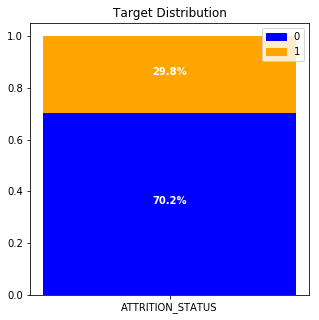

In [6]:
# start by having a look at the target variable
df_temp = df_prep[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

red_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/2
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)


## Data Prep

### Aggregate Categorical Variables

We loop through the list of categorical variables that require aggregating. Any category in the column that makes up less than `cat_perc_cutoff`percentage of cases is aggregated into a new category called 'Other'.

Since we will need to do this aggregation every time we want to score new data, we save the aggregations out into a json file for future use. We will add some additional data as we go through the notebook and save the json out before we finish. 

In [7]:
# Some of our categorical variables have categories that have very few cases, we will group these up into a new category called 'other' 

grouping_dict = {}

for col in l_cat_cols_for_grouping:
    df_temp = df_prep[col].value_counts(dropna=False).reset_index()
    df_temp['%'] = np.round(df_temp[col] / df_temp[col].sum(), 2)
    df_temp.rename(columns={'index' : col, col : 'Number of Occurances'}, inplace=True)
    # update the categorical names for any category where % doesn't meet the specified threshold
    updated_categories_dict = { i : 'Other' for i in list(df_temp[df_temp['%']< cat_perc_cutoff][col])}
    df_prep[col].replace(updated_categories_dict, inplace=True)
    # keep a record of the grouping as we will need to apply it when scoring new data
    grouping_dict[col] = updated_categories_dict

### Correlation Analysis

We carry out a correlation analysis on all variables specified in `l_numerical_features`.

From the result of the analysis we can see that the historical yearly usage is very highly correlated. This is most likely due to the nature of how this synthetic data was generated. We remove all but 1 of these variables from the numerical list. While they remain in our dataset they will be dropped from the transformer and not used as input into the model.

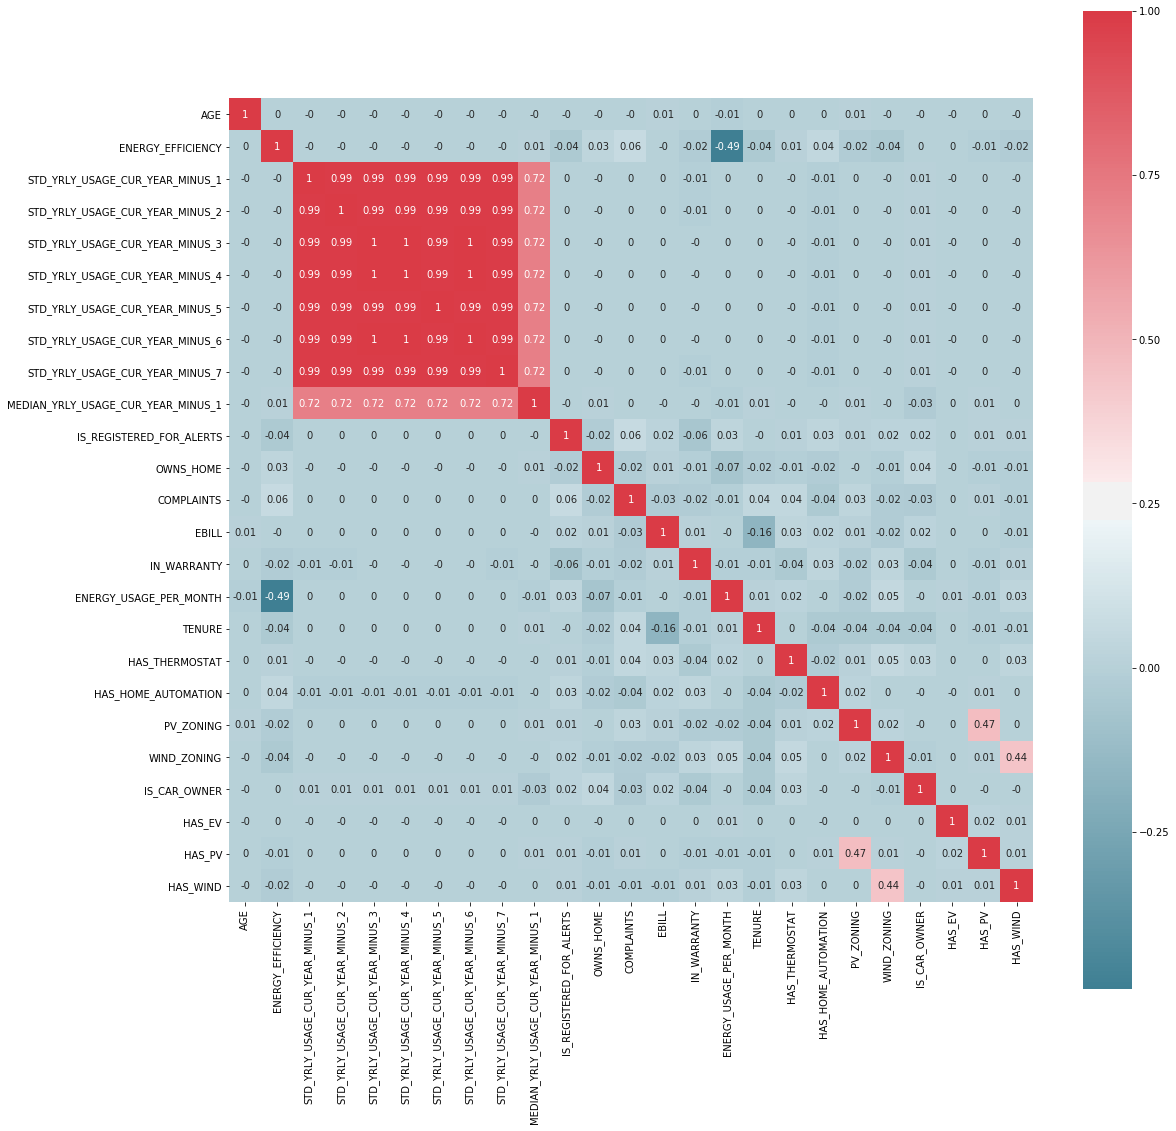

In [8]:
# check correlation between numerical features
f, ax = plt.subplots(figsize=(18, 18))
corr = df_prep[l_numerical_features].corr()
corr = corr.round(2)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

In [9]:
# the annual usage over the last 7 years is 100% correlated - a result of the how the synthetic data was generated 
# we can remove all but 1 of these variables
l_numerical_cols_to_drop = ['STD_YRLY_USAGE_CUR_YEAR_MINUS_2', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_3', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_4','STD_YRLY_USAGE_CUR_YEAR_MINUS_5', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_6', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_7']

# also remove them from the list of numerical features
l_numerical_features = [i for i in l_numerical_features if i not in l_numerical_cols_to_drop]

## Build Machine Learning Models

### Split Data and Build Transformer

We split the data into training, validation and test sets. We use 60% of the data for training, 20% for validation and the remaining 20% for testing. We build the models on the training set, carry out hyperparameter tuning on the validation set and finally apply the selected model to the unseen test set.  

We use built-in sklearn transformers to process the data and get it ready for input into the model. 

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputer`transformer to fill in missing values with 'Other'. Next we use `OneHotEncoder` to create dummy variables for each category. The transformers are applied to the features specified in the `l_categorical_for_dummy_vars`variable.

For numerical variables the pipeline has a single step in our example. We again use the `SimpleImputer`transformer to fill in missing values. The transformer is applied to the features specified in `l_numerical_features`variable.  

The transformers are combined, and to test it out, we fit and transform them to the training data. We then transform the test data.  

In [10]:
X = df_prep.drop([target_col], axis=1)
y = df_prep[target_col]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, stratify=y, test_size=0.40, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_val_test, y_val_test, stratify=y_val_test, test_size=0.50, random_state=0)

In [11]:
X_test.head()

,CUSTOMER_ID,GENDER_ID,FIRST_NAME,LAST_NAME,PHONE_1,EMAIL,AGE,ENERGY_USAGE_PER_MONTH,ENERGY_EFFICIENCY,IS_REGISTERED_FOR_ALERTS,...,SEGMENT,EMPLOYMENT,STD_YRLY_USAGE_CUR_YEAR_MINUS_1,STD_YRLY_USAGE_CUR_YEAR_MINUS_2,STD_YRLY_USAGE_CUR_YEAR_MINUS_3,STD_YRLY_USAGE_CUR_YEAR_MINUS_4,STD_YRLY_USAGE_CUR_YEAR_MINUS_5,STD_YRLY_USAGE_CUR_YEAR_MINUS_6,STD_YRLY_USAGE_CUR_YEAR_MINUS_7,MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1
47608,47609,2,Fay,Corwin,815-798-3626,Fay.Corwin@fannie.com,27,5530,0.628,1,...,NaN,Employed full-time,16543,14074,8888,8888,8888,8888,6666,20500
48878,48879,2,Adolphus,Goyette,219-279-4471,Adolphus.Goyette@adrienne.net,18,13900,0.368,1,...,SILVER,Retired,22963,15555,10864,10864,10864,10864,9629,26900
59310,59311,1,Henri,Stanton,772-708-1264,Henri.Stanton@loyal.com,25,3840,0.670,1,...,SILVER,Retired,15061,12592,6913,6913,6913,6913,6666,3210
34936,34937,2,Toby,Nader,630-570-6926,Toby.Nader@abigale.ca,41,14400,0.324,0,...,SILVER,Employed full-time,30864,24444,14814,14814,14814,14814,12592,26900
59052,59053,2,Dexter,Abshire,920-799-7270,Dexter.Abshire@luella.us,31,8010,0.640,0,...,SILVER,Employed part-time,8642,5185,2963,2963,2963,2963,2222,3210


In [12]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])

In [13]:
# we don't have any missing data in our dataset but we keep this here for demonstration purposes and as data for scoring may have missing data
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, l_numerical_features),
        ('cat', categorical_transformer, l_categorical_for_dummy_vars)
            ])

In [15]:
X_train_postprocess = preprocessor.fit_transform(X_train)
X_validation_postprocess = preprocessor.transform(X_validation)
X_test_postprocess = preprocessor.transform(X_test)

### Model Hyperparameter Tuning and Model Selection

We selected a random forest model for this example. We do some hyperparameter tuning and select the final hyperparameters based on the best AUC on the validation set. 

In [16]:
l_ne = [10, 50]
l_md = [5, 7, 10] 
l_mf = [0.75, 0.9]

highest_validation_auc = 0.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=0)
            clf.fit(X_train_postprocess, y_train)
            
            y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
            y_pred_validation = clf.predict_proba(X_validation_postprocess)[:,1]
            
            fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
            fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

            auc_validation = metrics.auc(fpr_validation, tpr_validation)
            auc_train = metrics.auc(fpr_train, tpr_train)

            if auc_validation > highest_validation_auc:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features***')
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_validation_auc = auc_validation
            else:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features')

Training AUC : 0.664, Validation AUC :0.659 from 10 estimators, 5 max depth and 0.75 max features***
Training AUC : 0.661, Validation AUC :0.653 from 10 estimators, 5 max depth and 0.9 max features
Training AUC : 0.772, Validation AUC :0.758 from 10 estimators, 7 max depth and 0.75 max features***
Training AUC : 0.765, Validation AUC :0.75 from 10 estimators, 7 max depth and 0.9 max features
Training AUC : 0.925, Validation AUC :0.903 from 10 estimators, 10 max depth and 0.75 max features***
Training AUC : 0.917, Validation AUC :0.895 from 10 estimators, 10 max depth and 0.9 max features
Training AUC : 0.675, Validation AUC :0.669 from 50 estimators, 5 max depth and 0.75 max features
Training AUC : 0.665, Validation AUC :0.66 from 50 estimators, 5 max depth and 0.9 max features
Training AUC : 0.797, Validation AUC :0.783 from 50 estimators, 7 max depth and 0.75 max features
Training AUC : 0.784, Validation AUC :0.772 from 50 estimators, 7 max depth and 0.9 max features
Training AUC : 0

### Build Final Model and Pipeline

Next we create a pipeline which combines the preprocessing steps of prepping the data and building the model with the selected hyperparameters. 

With this pipeline we can pass data in in it's raw form, with missing values and categorical data. The missing data is replaced and dummy variables are created, this prepped data is then passed to the model and the model results are returned.

In [17]:
# create the finalised pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0))])

clf = pipeline.fit(X_train, y_train)
y_pred_train = clf.predict_proba(X_train)[:,1]
clf.predict_proba(X_validation)
y_pred_validation = clf.predict_proba(X_validation)[:,1]
clf.predict_proba(X_test)
y_pred_test = clf.predict_proba(X_test)[:,1]

fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_train = metrics.auc(fpr_train, tpr_train)
auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')

Training AUC : 0.941, Validation AUC :0.917 and Test AUC :0.912 from 50 estimators, 10 max depth and 0.75 max features


### View Model Results

First we'll look at the plot of the ROC curve and use the area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(1-Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

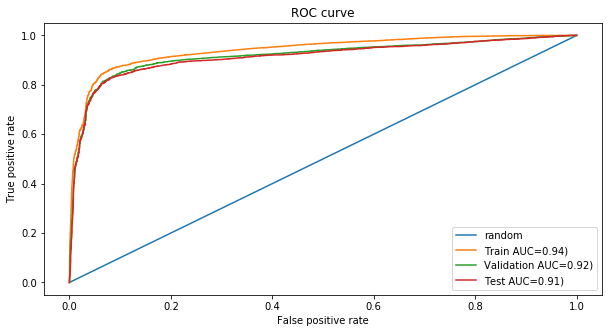

In [18]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

plt.plot(fpr_train, tpr_train, label= 'Train AUC=' + str(np.round(auc_train, 2)) + ')')
plt.plot(fpr_validation, tpr_validation, label= 'Validation AUC=' + str(np.round(auc_validation, 2)) + ')')
plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

Based on the validation ROC curve result we select the optimum threshold value based on Youden's Index. Any probabilities greater than the selected threshold will be classed as 1, otherwise 0. 

In [19]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_validation - fpr_validation)
opt_threshold = thresholds_validation[idx_opt_thres]

print(opt_threshold)

y_pred_class_train = y_pred_train >= opt_threshold
y_pred_class_train = y_pred_class_train.astype(int)
y_pred_class_validation = y_pred_validation >= opt_threshold
y_pred_class_validation = y_pred_class_validation.astype(int)
y_pred_class_test = y_pred_test >= opt_threshold
y_pred_class_test = y_pred_class_test.astype(int)

0.3330363505834015


We'll next look at the confusion matrix from the test set results at the selected threshold to summarise the performance of the model and see what types of errors are being made. We can see that, at the selected optimal threshold, the classifier does a good job of correctly classifying customers as attrited or not.  

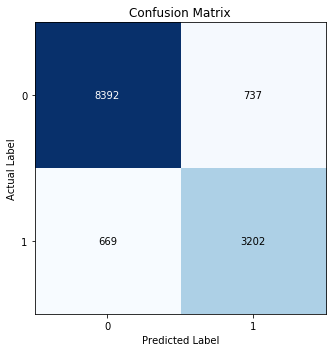

In [20]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])

fig  = plt.figure(figsize=(10,5))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1])
plt.yticks(tick_marks, [0, 1])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    plt.text(x, y, num_occurances, color="white" if confusion_matrix[x, y] > confusion_matrix.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

## Save the Pipeline to WML server

In the next steps we save and deploy the pipeline. The pipeline can be saved and deployed in the same way we save and deploy models. 

Before we save the pipeline we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the watson_machine_learning_client package to complete these steps. 

### User Inputs

The user can specify the names for the space, model and model deployment.

In [21]:
# Specify a name for the space being created, the saved model and the model deployment
#space_name = 'Utilities Customer Attrition Space'
model_name = 'attrition_pipeline'
deployment_name = 'attrition_pipeline_deployment'

In [22]:
!pip install --upgrade watson-machine-learning-client-V4

Requirement already up-to-date: watson-machine-learning-client-V4 in /cc-home/_global_/python-3.6 (1.0.55)


### define WML credentials and connect WML client

In [23]:
 wml_credentials = {
"instance_id": "wml_local",
"url" : "https://alexbar.ml.test.cloud.ibm.com:31843",
"username":"admin",
"password": "password",
"version": "2.5.0"
}

In [24]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)

ConnectionError: HTTPSConnectionPool(host='alexbar.ml.test.cloud.ibm.com', port=31843): Max retries exceeded with url: /v1/preauth/validateAuth (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f97a957bcc0>: Failed to establish a new connection: [Errno -2] Name or service not known',))

 ### Create deployment space in WML server

In [ ]:
# Enter the Deployment Space Name
 space_details = client.spaces.store(meta_props={client.spaces.ConfigurationMetaNames.NAME: "FromOutside421"})
 space_id = client.spaces.get_uid(space_details)
 space_id 

In [ ]:
client.set.default_space(space_id)

### Store pipeline details into created WML deployment space

In [ ]:
metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.20-py3",
    client.repository.ModelMetaNames.TAGS: [{'value' : 'utilities_attrition_pipeline_tag'}],
    client.repository.ModelMetaNames.SPACE_UID: space_id
}

stored_model_details = client.repository.store_model(model=clf, meta_props=metadata, training_data=X_train, training_target=y_train, feature_names=X_train.columns)
stored_model_details

### Deploy the model

In [ ]:
metadata_dict = {'grouping_cols' : grouping_dict, 'probability_threshold' : opt_threshold}

In [ ]:
# deploy the model pipeline
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [{'value' : 'utilities_attrition_deployment_tag'}],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.CUSTOM: metadata_dict
}

# deploy the model

model_uid = stored_model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)

### In case you want to promote data set into deployment space, you can use this code

In [ ]:
asset_details = client.data_assets.create(name="Attrition View.csv",file_path="/project_data/data_asset/Attrition View.csv")